In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import svm
from mlxtend.regressor import StackingCVRegressor
from lightgbm import LGBMRegressor

In [2]:
train_df =  pd.read_excel('Data_Train.xlsx')
test_df=pd.read_excel('Test_set.xlsx')

In [3]:
big_df = train_df.append(test_df)
big_df.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
dtype: object

In [4]:
big_df['Date'] = big_df['Date_of_Journey'].str.split('/').str[0]
big_df['Month'] = big_df['Date_of_Journey'].str.split('/').str[1]
big_df['Year'] = big_df['Date_of_Journey'].str.split('/').str[2]

big_df['Date'] = big_df['Date'].astype(int)
big_df['Month'] = big_df['Month'].astype(int)
big_df['Year'] = big_df['Year'].astype(int)

big_df=big_df.drop(['Date_of_Journey'], axis=1)


In [5]:
big_df['Arrival_Time'] = big_df['Arrival_Time'] .str.split(' ').str[0]
big_df['Total_Stops']=big_df['Total_Stops'].fillna('1 stop')
big_df['Total_Stops']=big_df['Total_Stops'].replace('non-stop','0 stop')
big_df['Stop'] = big_df['Total_Stops'].str.split(' ').str[0]
big_df['Stop'] = big_df['Stop'].astype(int)
big_df=big_df.drop(['Total_Stops'], axis=1)

In [6]:
big_df['Arrival_Hour'] = big_df['Arrival_Time'] .str.split(':').str[0]
big_df['Arrival_Minute'] = big_df['Arrival_Time'] .str.split(':').str[1]

big_df['Arrival_Hour'] = big_df['Arrival_Hour'].astype(int)
big_df['Arrival_Minute'] = big_df['Arrival_Minute'].astype(int)
big_df=big_df.drop(['Arrival_Time'], axis=1)


In [7]:
big_df['Dep_Hour'] = big_df['Dep_Time'] .str.split(':').str[0]
big_df['Dep_Minute'] = big_df['Dep_Time'] .str.split(':').str[1]
big_df['Dep_Hour'] = big_df['Dep_Hour'].astype(int)
big_df['Dep_Minute'] = big_df['Dep_Minute'].astype(int)
big_df=big_df.drop(['Dep_Time'], axis=1)


In [8]:
big_df['Route_1'] = big_df['Route'] .str.split('→ ').str[0]
big_df['Route_2'] = big_df['Route'] .str.split('→ ').str[1]
big_df['Route_3'] = big_df['Route'] .str.split('→ ').str[2]
big_df['Route_4'] = big_df['Route'] .str.split('→ ').str[3]
big_df['Route_5'] = big_df['Route'] .str.split('→ ').str[4]

big_df['Price'].fillna((big_df['Price'].mean()), inplace=True)


In [9]:

big_df['Route_1'].fillna("None",inplace = True)
big_df['Route_2'].fillna("None",inplace = True)
big_df['Route_3'].fillna("None",inplace = True)
big_df['Route_4'].fillna("None",inplace = True)
big_df['Route_5'].fillna("None",inplace = True)

big_df.describe()


,Price,Date,Month,Year,Stop,Arrival_Hour,Arrival_Minute,Dep_Hour,Dep_Minute
count,13354.000000,13354.000000,13354.000000,13354.0,13354.000000,13354.000000,13354.000000,13354.000000,13354.000000
mean,9087.064121,13.389846,4.710574,2019.0,0.826045,13.396061,24.664146,12.513254,24.507264
std,4124.447805,8.439060,1.165622,0.0,0.674608,6.896145,16.559723,5.736273,18.832385
min,1759.000000,1.000000,3.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6135.250000,6.000000,3.000000,2019.0,0.000000,8.000000,10.000000,8.000000,5.000000
50%,9087.064121,12.000000,5.000000,2019.0,1.000000,14.000000,25.000000,11.000000,25.000000
75%,11087.000000,21.000000,6.000000,2019.0,1.000000,19.000000,35.000000,18.000000,40.000000
max,79512.000000,27.000000,6.000000,2019.0,4.000000,23.000000,55.000000,23.000000,55.000000


In [10]:
big_df=big_df.drop(['Route'], axis=1)
big_df=big_df.drop(['Duration'], axis=1)

In [11]:
from sklearn.preprocessing import LabelEncoder

lb_encode = LabelEncoder()
big_df["Additional_Info"] = lb_encode.fit_transform(big_df["Additional_Info"])
big_df["Airline"] = lb_encode.fit_transform(big_df["Airline"])
big_df["Destination"] = lb_encode.fit_transform(big_df["Destination"])
big_df["Source"] = lb_encode.fit_transform(big_df["Source"])
big_df['Route_1']= lb_encode.fit_transform(big_df["Route_1"])
big_df['Route_2']= lb_encode.fit_transform(big_df["Route_2"])
big_df['Route_3']= lb_encode.fit_transform(big_df["Route_3"])
big_df['Route_4']= lb_encode.fit_transform(big_df["Route_4"])
big_df['Route_5']= lb_encode.fit_transform(big_df["Route_5"])

In [12]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns  
    
missing_values_table(big_df)


Your selected dataframe has 18 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [13]:
df_train = big_df[0:10683]
df_test = big_df[10683:]
df_test = df_test.drop(['Price'], axis =1)

X = df_train.drop(['Price'], axis=1)
y = df_train.Price

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [15]:
lm = LinearRegression()

In [16]:
#Build our cross validation method
kfolds = KFold(n_splits=50,shuffle=True, random_state=100)

In [17]:
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)


benchmark_model = make_pipeline(RobustScaler(),
                                lm).fit(X=X_train, y=y_train)
print('cv_rmse',cv_rmse(benchmark_model).mean())

cv_rmse 3238.316987636253


In [18]:
from sklearn.linear_model import RidgeCV

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(X_train, y_train)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

Text(0, 0.5, 'score')

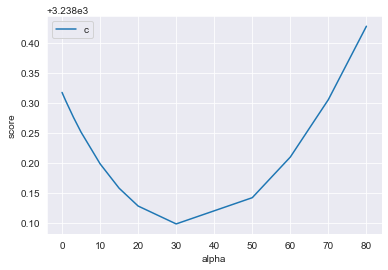

In [19]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

In [20]:
ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
print('ridge_score_table',ridge_score_table)

alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(X_train, y_train)

cv_rmse(ridge_model2).mean()


ridge_score_table                 RMSE
0.0001   3238.316986
0.0003   3238.316983
0.0005   3238.316980
0.0007   3238.316977
0.0009   3238.316974
0.0100   3238.316841
0.0500   3238.316253
0.1000   3238.315520
0.3000   3238.312603
1.0000   3238.302585
3.0000   3238.275551
5.0000   3238.250778
10.0000  3238.198049
15.0000  3238.157376
20.0000  3238.127663
30.0000  3238.097862
50.0000  3238.141578
60.0000  3238.209316
70.0000  3238.305034
80.0000  3238.427310


3238.153926834791

In [21]:
alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(X_train, y_train)
scores = lasso_model2.steps[1][1].mse_path_


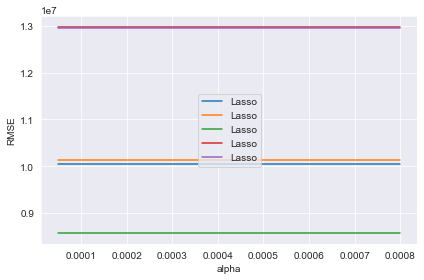

In [22]:
plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [23]:
cv_rmse(lasso_model2).mean()

3238.3169506199984

In [24]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(X_train, y_train)

In [25]:
cv_rmse(elastic_model3).mean()

3238.2960573475075

In [27]:
# # XGBoost 
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from xgboost import XGBRegressor

In [28]:
def modelfit(alg, dtrain, target, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, 
                              label=y.values)
        
        print("\nGetting Cross-validation result..")
        cvresult = xgb.cv(xgb_param, xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,metrics='rmse', 
                          early_stopping_rounds=early_stopping_rounds,
                          verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print("\nFitting algorithm to data...")
    alg.fit(dtrain, target, eval_metric='rmse')
        
    #Predict training set:
    print("\nPredicting from training data...")
    dtrain_predictions = alg.predict(dtrain)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(mean_squared_error(target.values,
                                             dtrain_predictions)))


In [29]:
xgb3 = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,max_bin=20,
                     colsample_bytree=0.8,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X_train, y_train)
cv_rmse(xgb_fit).mean()

[16:28:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

1275.7728910228686

In [30]:
cv_rmse(xgb_fit).mean()

[16:31:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:31:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

1275.7728910228686

In [31]:
# # Support vector machine
from sklearn import svm
svr_opt = svm.SVR(C = 100000, gamma = 1e-08)

svr_fit = svr_opt.fit(X_train, y_train)
cv_rmse(svr_fit).mean()

4191.657759309574

In [32]:
# # Light GBM 
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =20, min_sum_hessian_in_leaf = 11)
lgbm_fit = lgbm_model.fit(X_train, y_train)
cv_rmse(lgbm_fit).mean()

1407.8466599458975

In [33]:
# # STACKING
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))


xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.8,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006))
 

#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)



#prepare dataframes
stackX = np.array(X_train)
stacky = np.array(y_train)

In [34]:
# # STACKING
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))


xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.8,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006))
 

#stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)



#prepare dataframes
stackX = np.array(X_train)
stacky = np.array(y_train)

In [35]:
stack_gen_model = stack_gen.fit(stackX, stacky)

[16:44:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
em_preds = elastic_model3.predict(X_test)
lasso_preds = lasso_model2.predict(X_test)
ridge_preds = ridge_model2.predict(X_test)
stack_gen_preds = stack_gen_model.predict(X_test)
xgb_preds = xgb_fit.predict(X_test)
#svr_preds = svr_fit.predict(X_test)
lgbm_preds = lgbm_fit.predict(X_test)

In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = np.sqrt(mean_squared_error(y_test, stack_gen_preds))
print("RMSE: %f" % (rmse))


RMSE: 1332.478521


In [40]:
df_test_xgb = df_test[['Additional_Info', 'Airline', 'Destination', 'Source', 'Date', 'Month',
       'Year', 'Stop', 'Arrival_Hour', 'Arrival_Minute', 'Dep_Hour',
       'Dep_Minute', 'Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']]
preds_1 = stack_gen_model.predict(df_test_xgb)
df_test_xgb['Price'] = preds_1
df_test_xgb.to_csv('flight_price_5.csv')

D:\USERS\akanksha\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
